# Love Number Calculations
In this cookbook we will explore how we can use TidalPy's multilayer functions to estimate the response of a planet to tidal or other loading stresses via the complex Love numbers.

**References**:
- SVC16  : Sabadini, Vermeerson, & Cambiotti (2016), DOI: [10.1007/978-94-017-7552-6](https://doi.org/10.1007/978-94-017-7552-6).
- HH14   : Henning & Hurford (2014), DOI: [10.1088/0004-637X/789/1/30](https://doi.org/10.1088/0004-637X/789/1/30).
- TB05   : Tobie et al. (2005), DOI: [10.1016/j.icarus.2005.04.006](https://doi.org/10.1016/j.icarus.2005.04.006).
- S74    : Saito (1974), DOI: [10.4294/jpe1952.22.123](https://doi.org/10.4294/jpe1952.22.123).
- TS72   : Takeuchi & Saito (1972), DOI: [10.1016/B978-0-12-460811-5.50010-6](http://dx.doi.org/10.1016/B978-0-12-460811-5.50010-6).
- KMN15  : Kamata et al. (1972), DOI: [10.1002/2015JE004821](http://dx.doi.org/10.1002/2015JE004821).
- M16    : Martens (2016, [PhD Thesis](https://resolver.caltech.edu/CaltechTHESIS:04102016-211741759)), DOI: [10.7907/Z9N29TX7](http://dx.doi.org/10.7907/Z9N29TX7).
- ID     : [IcyDwarf Code](https://github.com/MarcNeveu/IcyDwarf/blob/master/IcyDwarf/Thermal.h) written by Marc Neveu.

In [1]:
import sys
import time
from functools import lru_cache

import numpy as np
from ipywidgets import interact, widgets
import matplotlib.pyplot as plt
%matplotlib notebook

# Load TidalPy's Helper Functions
from TidalPy.utilities.conversions import days2rads
from TidalPy.utilities.spherical_helper import calculate_mass_gravity_arrays

# Load TidalPy's Rheology Functions
from TidalPy.rheology import Maxwell, Burgers, Andrade, Sundberg, Newton

# Load TidalPy's RadialSolver Module
from TidalPy.RadialSolver import radial_solver

rheologies = {
    'Maxwell': Maxwell,
    'Burgers': Burgers,
    'Andrade': Andrade,
    'Sundberg-Cooper': Sundberg,
    'Newton': Newton
}

integration_method = "RK45"

widget_styles = {
    'layout': {'width': '50%'},
    'style': {'description_width': 'initial'}
}

def clear_line():
    # Can't get ANSI escape codes to work properly in Jupyter so this is a hack.
    #   The ANSI code would be "\033[1A\033[K"
    print('\r                                             ', end='\r')

## Setup functions

In [2]:
def calculate_planet(build_func, **build_func_kwargs):
    
    # Get planet information
    indices, layer_types, bulk_density, \
        radius, density, gravity, shear_modulus, bulk_modulus, viscosity, \
        planet_frequency = build_func(**build_func_kwargs)
    radius_km = radius / 1000.
    planet_radius      = radius[-1]
    original_ic_radius = radius[indices[0]][-1]
    original_oc_radius = radius[indices[1]][-1]
    original_ic_frac   = original_ic_radius / radius[-1]
    original_oc_frac   = original_oc_radius / radius[-1]
    
    # Setup figure
    fig, axes = plt.subplots(ncols=3, nrows=2, sharey='all')
    plt.subplots_adjust(hspace=0.45)
    tidal_lines = list()
    loading_lines = list()
    icb_lines = list()
    cmb_lines = list()
    twin_axes = list()
    for ax_i, ax in enumerate(axes.flatten()):
        ax2 = ax.twiny()
        twin_axes.append(ax2)
        if ax_i in [0, 3]:
            ax.set(ylabel='Radius [km]')
        ax.set(xlabel='$y_{' + f'{ax_i+1}' + '}$')
        tidal_lines.append((
            ax.plot([0], [0], c='blue', label='Tidal', ls='-')[0],
            ax2.plot([0], [0], c='blue', ls=':')[0]
        ))
        loading_lines.append((
            ax.plot([0], [0], c='orange', label='Loading', ls='-')[0],
            ax2.plot([0], [0], c='orange', ls=':')[0]
        ))
        icb_lines.append(ax.axhline(0, c='k', ls='--'))
        cmb_lines.append(ax.axhline(0, c='k', ls='--'))
    
#     @lru_cache
    def update_calculations(rheology_name, forcing_period, degree_l,
                            inner_core_frac, outer_core_frac,
                            solid_dynamic, liquid_dynamic, solve_load_numbers,
                            integration_atol, integration_rtol):
        
        # Rebuild planet with updated inner and outer core radii
        indices, is_solid, bulk_density, \
            radius, density, gravity, shear_modulus, bulk_modulus, viscosity, \
            planet_frequency = build_func(inner_core_radius=inner_core_frac*planet_radius,
                                          outer_core_radius=outer_core_frac*planet_radius,
                                          **build_func_kwargs)
        
        # Use pre-defined frequency or user-defined
        if forcing_period == 0.:
            # Pre-defined
            frequency = planet_frequency
        else:
            # Use user-defined
            frequency = days2rads(forcing_period)
        
        # Calculate complex shear
        complex_shear = np.empty(radius.size, dtype=np.complex128)
        # Use user-provided rheology for all solid layers; Newton for liquid
        solid_rheology_inst = rheologies[rheology_name]()
        solid_rheology_inst.vectorize_modulus_viscosity(frequency, shear_modulus, viscosity, complex_shear)
        
        liquid_rheology_inst = rheologies['Newton']()
        l_index = indices[1]  # Liquid Outer Core is the 2nd layer
        liquid_rheology_inst.vectorize_modulus_viscosity(
            frequency, shear_modulus[l_index], viscosity[l_index], complex_shear[l_index])
        
        # Setup dynamic or solid assumption
        is_static = list()
        is_incompressible = list()
        upper_radius = list()
        for i, layer_is_solid in enumerate(is_solid):
            layer_index = indices[i]
            if np.sum(layer_index) > 0:
                if layer_is_solid:
                    is_static.append(not solid_dynamic)
                else:
                    is_static.append(not liquid_dynamic)
                is_incompressible.append(False)
                upper_radius.append(radius[layer_index][-1])

        solve_for = ['tidal']
        if solve_load_numbers:
            solve_for.append('loading')
        
        # Calculate radial solution
        integration_rtol = 10**integration_rtol
        integration_atol = 10**integration_atol
        solution = radial_solver(radius, density, gravity, bulk_modulus, complex_shear,
                              frequency, bulk_density,
                              tuple(layer_types), tuple(is_static), tuple(is_incompressible),
                              upper_radius_by_layer=tuple(upper_radius),
                              degree_l=degree_l, solve_for=tuple(solve_for),
                              integration_method=integration_method,
                              use_kamata=True,
                              integration_rtol=integration_rtol, integration_atol=integration_atol)
        
        assert solution.success
        love_tuple = list()
        sol_y = list()
        for j in range(len(solve_for)):
            for i in range(3):
                love_tuple.append(solution.love[j, i])
            sol_y.append(solution.result[j:6*(j+1), :])
        love_tuple = tuple(love_tuple)
        if len(solve_for) == 1:
            sol_y = sol_y[0]
        return sol_y, love_tuple
    
    
    def update(rheology_name, forcing_period, degree_l,
               inner_core_frac, outer_core_frac,
               solid_dynamic, liquid_dynamic, solve_load_numbers,
               integration_atol, integration_rtol):
        
        # Perform calculations
        clear_line()
        print('Calculating Radial Solution...', end='\r')
        t0 = time.time()
        y_sol, loves = update_calculations(rheology_name, forcing_period, degree_l,
                                           inner_core_frac, outer_core_frac,
                                           solid_dynamic, liquid_dynamic, solve_load_numbers,
                                           integration_atol, integration_rtol)
        delta_t = time.time() - t0
        if solve_load_numbers:
            tidal_sol, load_sol = y_sol
            k_tidal, h_tidal, l_tidal, k_load, h_load, l_load = loves
            clear_line()
            out_str  = f'Completed in: {delta_t:0.4f}s. Degree l = {degree_l}. '
            out_str += f'Tidal k, h, l = {np.real(k_tidal):0.3f}, {np.real(h_tidal):0.3f}, {np.real(l_tidal):0.3f}. '
            out_str += f'Load k, h, l = {np.real(k_load):0.3f}, {np.real(h_load):0.3f}, {np.real(l_load):0.3f}.'
            print(out_str, end='\r')
        else:
            tidal_sol = y_sol
            k_tidal, h_tidal, l_tidal = loves
            clear_line()
            out_str  = f'Completed in: {delta_t:0.4f}s. Degree l = {degree_l}. '
            out_str += f'Tidal k, h, l = {np.real(k_tidal):0.3f}, {np.real(h_tidal):0.3f}, {np.real(l_tidal):0.3f}.'
            print(out_str, end='\r')
        
#         # Update plot axis
#         ax_radial.clear()
#         ax_tang.clear()
        
        # Update ICB/CMB reference lines
        for icb_line, cmb_line in zip(icb_lines, cmb_lines):
            icb_line.set_ydata(inner_core_frac*planet_radius/1000.)
            cmb_line.set_ydata(outer_core_frac*planet_radius/1000.)

        # Update Tidal Results
        for t_i, tidal_line_tuple in enumerate(tidal_lines):
            x_data = tidal_sol[t_i, :]
            tidal_line_tuple[0].set_data(np.real(x_data), radius_km)
            tidal_line_tuple[1].set_data(np.imag(x_data), radius_km)
        
        # Update Loading Results
        for t_i, loading_line_tuple in enumerate(loading_lines):
            if solve_load_numbers:
                x_data = load_sol[t_i, :]
                loading_line_tuple[0].set_data(np.real(x_data), radius_km)
                loading_line_tuple[1].set_data(np.imag(x_data), radius_km)
            else:
                loading_line_tuple[0].set_data([0], [0])
                loading_line_tuple[1].set_data([0], [0])
            
        # Update limits
        for ax_i, ax in enumerate(axes.flatten()):
            ax.relim()
            ax.autoscale_view()
        for ax_i, ax in enumerate(twin_axes):
            ax.relim()
            ax.autoscale_view()
        
        # Reshow plot
        fig.canvas.draw()
        
    # Setup interactive plot
    interact(update,
             rheology_name = widgets.Dropdown(
                 options=['Maxwell', 'Burgers', 'Andrade', 'Sundberg-Cooper'],
                 value='Andrade',
                 description='Rheology:',
                 disabled=False, **widget_styles
             ),
             forcing_period = widgets.IntSlider(
                 min=0,
                 max=50,
                 step=1,
                 value=0,
                 description='Forcing Period [Days]:', **widget_styles
             ),
             degree_l = widgets.IntSlider(
                 min=2,
                 max=5,
                 step=1,
                 value=2,
                 description='Degree $l$:', **widget_styles
             ),
             inner_core_frac = widgets.FloatSlider(
                 value=original_ic_frac,
                 min=0.05,
                 max=0.9,
                 step=0.05,
                 description='IC-Fraction',
                 disabled=False,
                 readout_format='.2f',
                 indent=False, **widget_styles
             ),
             outer_core_frac = widgets.FloatSlider(
                 value=original_oc_frac,
                 min=0.15,
                 max=0.95,
                 step=0.05,
                 description='OC-Fraction',
                 disabled=False,
                 readout_format='.2f',
                 indent=False, **widget_styles
             ),
             solid_dynamic = widgets.Checkbox(
                 value=False,
                 description='Dynamic Solid',
                 disabled=False,
                 indent=False, **widget_styles
             ),
             liquid_dynamic = widgets.Checkbox(
                 value=False,
                 description='Dynamic Liquid (Unstable!)',
                 disabled=False,
                 indent=False, **widget_styles
             ),
             solve_load_numbers = widgets.Checkbox(
                 value=False,
                 description='Solve Load Numbers',
                 disabled=False,
                 indent=False, **widget_styles
             ),
             integration_atol = widgets.IntSlider(
                 min=-15,
                 max=-3,
                 step=1,
                 value=-7,
                 description='Integration atol ($10^{x}$):', **widget_styles
             ), 
             integration_rtol = widgets.IntSlider(
                 min=-15,
                 max=-3,
                 step=1,
                 value=-6,
                 description='Integration rtol ($10^{x}$):', **widget_styles
             ),
            )

## Four Layer Planet (Mercury-like)

In [3]:
# ! test r0 = 0

def build_four_layer(inner_core_radius=None, outer_core_radius=None, crust_radius=None, quasi_liquid=False):
    # Numerical Settings
    N = 100

    # Build Planet
    # # Radius
    if inner_core_radius is None:
        inner_core_radius = 1500.0e3
    if outer_core_radius is None:
        outer_core_radius = 2000.0e3
    if crust_radius is None:
        crust_radius      = 2440.0e3
    mantle_radius = crust_radius - 100.0e3
    
    # User may have provided unrealistic IC/OC fractions. Fix those here
    if inner_core_radius < 1.e3:
        inner_core_radius = 1.e3
    if outer_core_radius < 3.e3:
        outer_core_radius = 3.e3
    if inner_core_radius >= (outer_core_radius - 1.e3):
        inner_core_radius = outer_core_radius - 1.e3
    if outer_core_radius >= (mantle_radius - 1.e3):
        outer_core_radius = mantle_radius - 1.e3

    # # Index
    radius = np.linspace(0.1, crust_radius, N)
    inner_core_index = radius <= inner_core_radius
    outer_core_index = np.logical_and(radius > inner_core_radius,
                                      radius <= outer_core_radius)
    mantle_index     = np.logical_and(radius > outer_core_radius,
                                      radius <= mantle_radius)
    crust_index      = radius > mantle_radius
    
    # # Layer Parameters
    indices = (inner_core_index, outer_core_index, mantle_index, crust_index)
    if quasi_liquid:
        layer_types = ("solid", "solid", "solid", "solid")
    else:
        layer_types = ("solid", "liquid", "solid", "solid")

    # # Density
    density = np.empty_like(radius)
    density[inner_core_index] = 8750.
    density[outer_core_index] = 7850.
    density[mantle_index]     = 3200.
    density[crust_index]      = 2600.

    # # Shear Modulus
    shear_modulus = np.empty_like(radius)
    shear_modulus[inner_core_index] = 100.0e9
    shear_modulus[outer_core_index] = 0.0
    shear_modulus[mantle_index]     = 50.0e9
    shear_modulus[crust_index]      = 10.0e9

    # # Bulk Modulus
    bulk_modulus = np.empty_like(radius)
    bulk_modulus[inner_core_index] = 199.0e9
    bulk_modulus[outer_core_index] = 80.0e9
    bulk_modulus[mantle_index]     = 120.0e9
    bulk_modulus[crust_index]      = 90.0e9

    # # Viscosity
    viscosity = np.empty_like(radius)
    viscosity[inner_core_index] = 1.0e24
    viscosity[outer_core_index] = np.logspace(3, 11, np.sum(outer_core_index), dtype=np.float64)
    viscosity[mantle_index]     = 1.0e20
    viscosity[crust_index]      = 1.0e26

    # # Gravity 
    volume, mass, gravity = calculate_mass_gravity_arrays(radius, density)
    bulk_density = np.sum(mass) / np.sum(volume)
    
    # # Orbital Period
    frequency = days2rads(87.96926)
    
    return indices, layer_types, bulk_density, radius, density, gravity, shear_modulus, bulk_modulus, viscosity, frequency

<IPython.core.display.Javascript object>


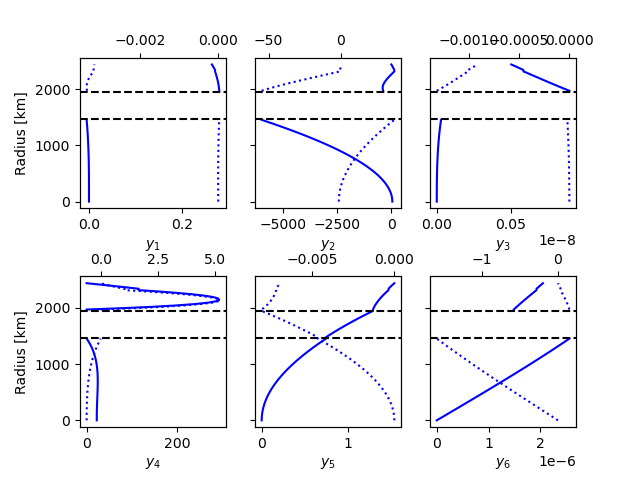

interactive(children=(Dropdown(description='Rheology:', index=2, layout=Layout(width='50%'), options=('Maxwell…

In [4]:
# Run Model!
calculate_planet(build_four_layer)

### Quasi-Liquid Assumption
In the typical liquid assumption (used in the above example) the layer's shear modulus is assumed to be zero. This leads to zero Shear stress (represented by $y_{4}$), and a the shear displacement ($y_{3}$) to become a function of the forcing frequency and the other radial functions (its derivative is no longer required: it can be solved exactly). 

Here we will test a new type of layer referred to as the "quasi"-liquid assumption. In this model, the real part of the shear modulus is still zero, but the imaginary portion is allowed to be non-zero. This has applicability if the fluid is behaving like a Newtonian fluid where the complex shear modulus can be defined as:
$$\bar{\mu} = 0 + w \eta$$

In [5]:
# Run Model with Quasi-Liquid Assumption!
# TODO: Quasi-liquid assumption will be released in a future version of TidalPy
# calculate_planet(build_four_layer, quasi_liquid=True)